# Process observational large ensemble time series data into variability data

__2. Process the time series data into variability confidence intervals for each dataset.__

Resample for time periods 3-120 years (to compare with 1900-2020 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (3-120 years) and IPCC region containing a 95% confidence interval on unforced TAS trends.


Our first protocol is to exclude data with missing values entirely.

I want to generate a start date based on availability and then index the trend data by duration. This will be a better and more inclusive method.

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import dask
import warnings

%matplotlib inline

__Processed Data directory:__  

Time series of TAS for each IPCC region.

In [2]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [3]:
def get_trends_allstartyears(
    data,
    duration,
    startyears,
    dim='year',
    dask=False,
):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel({dim:slice(_startyr,_endyr)}) # index differently here because the dates are different

        # Calculate the slope
        # print(_tsel)
        # print(dim)
        if dask:
            _tsel_polyfit = dask.delayed(xr.DataArray.polyfit)(_tsel, dim=dim, deg=1, skipna=True)['polyfit_coefficients'].sel(degree=1)
        else:
            _tsel_polyfit = xr.DataArray.polyfit(_tsel, dim=dim, deg=1, skipna=True)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop_vars('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
    
    if dask:
        trends_list = dask.compute(*trends_list)
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [4]:
def compute_trends_wrapper(
    data,
    durations=np.arange(5,81,),
    time_dim="year",
    metadata=True,
    mask_nan=True,
    dask=False,
    startyears=None,
    **kwargs,
):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data[time_dim][0]
    last_year  = data[time_dim][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        if startyears is None:
            _startyears = np.arange(first_year,last_year+2-duration,1)
        else:
            _startyears = startyears

        if dask:
            allvar_onedur_ds = dask.delayed(get_trends_allstartyears)(
                data,
                duration=duration,
                startyears=_startyears,
                dim=time_dim,
                **kwargs
            )
        else:
            allvar_onedur_ds = get_trends_allstartyears(
                data,
                duration=duration,
                startyears=_startyears,
                dim=time_dim,
                **kwargs
            )            
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
    
    if dask:
        trends_allstartyear_allduration_list = dask.compute(*trends_allstartyear_allduration_list)
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list, dim='duration')
    del trends_allstartyear_allduration_list

    # Add metadata
    if metadata:
        trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName.data)})
        trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev.data)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    # Mask where the data is a nan at the end of the time series.
    if mask_nan:
        trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.where(~np.isnan(data.rename({time_dim:"duration"})))
    
    return trends_allstartyear_allduration_ds

### Collect file paths.

#### Collect GISTEMP 5x5 file paths.

In [ ]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg/ensembleChunks*.reindexed.IPCCRegions.*.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [5]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0*reindexed.IPCCRegions*.nc' % obslens_tseries_dir)
hadcrut5_files.sort()

#### Collect DCENT (unfilled) file paths.

In [6]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023*reindexed.IPCCRegions.*.nc' % obslens_tseries_dir)
dcent_unfilled_files.sort()

### Compute trends for all durations and save

In [7]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"

#### GISTEMP 5x5

In [9]:
gistemp_5x5_ds = xr.open_dataset(*gistemp_5x5_files)

In [10]:
warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")
gistemp_trends_all = compute_trends_wrapper(
    gistemp_5x5_ds[gistemp_tas_var],
    durations=np.arange(3,122,1),
    time_dim="recordlength",
)

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

In [11]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/xagg/'))

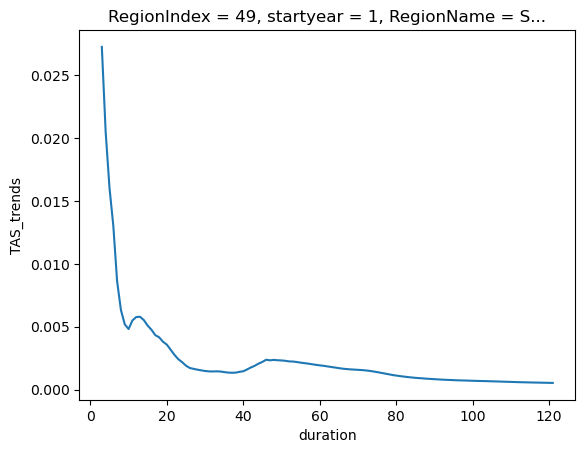

In [12]:
gistemp_trends_all.sel(RegionIndex=49, startyear=1).std("realization").plot()

In [13]:
del gistemp_5x5_ds, gistemp_trends_all

#### HadCRUT5

In [8]:
hadcrut5_ds = xr.open_dataset(*hadcrut5_files)

In [9]:
warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")
hadcrut5_trends_all = compute_trends_wrapper(
    hadcrut5_ds[hadcrut5_tas_var],
    durations=np.arange(3,122,1),
    time_dim="recordlength",
)

3 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

4 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

5 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

6 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

7 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

8 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

9 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

10 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

11 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

12 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

13 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

14 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

15 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


16 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


17 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


18 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


19 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


20 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


21 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


22 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


23 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


24 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


25 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


26 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


27 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


28 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


29 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


30 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


31 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


32 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


33 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


34 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


35 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


36 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


37 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


38 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


39 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


40 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


41 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


42 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


43 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


44 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


45 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


46 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


47 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


48 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


49 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


50 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


51 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


52 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


53 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


54 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


55 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


56 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


57 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


58 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


59 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


60 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


61 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


62 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


63 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


64 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


65 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


66 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


67 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


68 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


69 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


70 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


71 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


72 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


73 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


74 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


75 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


76 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


77 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


78 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


79 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


80 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


81 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


82 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


83 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


84 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


85 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


86 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 

In [12]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.IPCCRegions.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/xagg'))

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


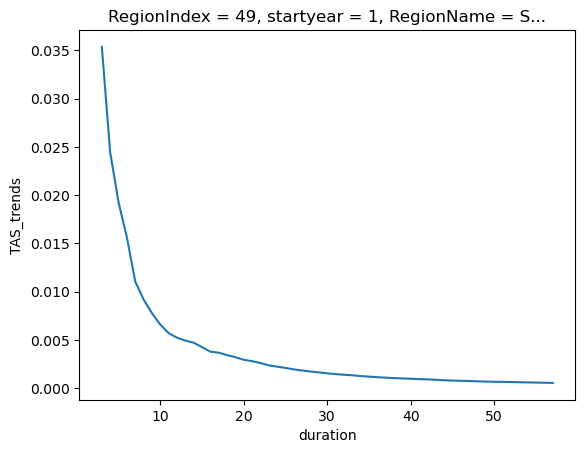

In [34]:
hadcrut5_trends_all.sel(RegionIndex=49, startyear=1).std("realization").plot()

In [35]:
del hadcrut5_ds,hadcrut5_trends_all

#### DCENT (unfilled)

In [36]:
dcent_unfilled_ds = xr.open_dataset(*dcent_unfilled_files)

In [37]:
warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")
dcent_unfilled_trends_all = compute_trends_wrapper(
    dcent_unfilled_ds[dcent_unfilled_tas_var],
    durations=np.arange(3,122,1),
    time_dim="recordlength",
)

3 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

4 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

5 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

6 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

7 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

8 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

9 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

10 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

11 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

12 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

13 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

14 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

15 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

16 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

17 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

18 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

19 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

20 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

21 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

22 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

23 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

24 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

25 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

26 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

27 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

28 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

29 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

30 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

31 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

32 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

33 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

34 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

35 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

36 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

37 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

38 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

39 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

40 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

41 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

42 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

43 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

44 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

45 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

46 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

47 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

48 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

49 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

50 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

51 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

52 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

53 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

54 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

55 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

56 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

57 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

58 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

59 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

60 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

61 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

62 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

63 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

64 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

65 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

66 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

67 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

68 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

69 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

70 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

71 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

72 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

73 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

74 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

75 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

76 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

77 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

78 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

79 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

80 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

81 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

82 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

83 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

84 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

85 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

86 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

87 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

88 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

89 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

90 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

91 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

92 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

93 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

94 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

95 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

96 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

97 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

98 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

99 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

100 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

101 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

102 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

103 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

104 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

105 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

106 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

107 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

108 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

109 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site

110 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


111 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


112 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


113 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


114 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


115 116 117 118 119 120 121 

In [39]:
dcent_unfilled_trends_all.to_netcdf('%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.IPCCRegions.190001-202312.nc' % (obslens_tseries_dir,'DCENT/20240901/xagg'))

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


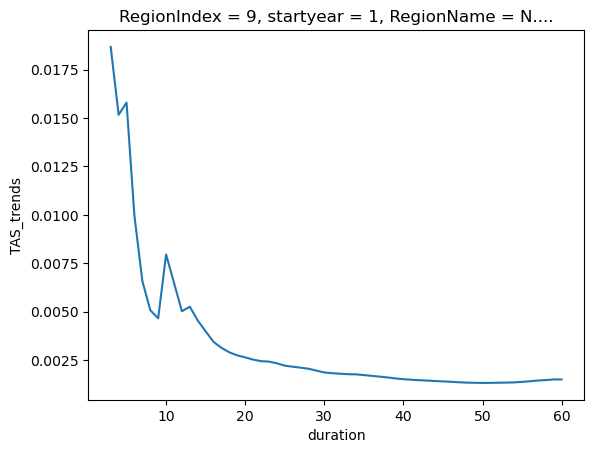

In [40]:
dcent_unfilled_trends_all.sel(RegionIndex=9, startyear=1).std("realization").plot()

In [61]:
del dcent_unfilled_ds, dcent_unfilled_trends_all

## Now compute the trends for the spatial data.

### Collect file paths.

#### Collect GISTEMP 5x5 file paths.

In [5]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg/ensembleChunks*.reindexed.5x5.*.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [62]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0*reindexed.5x5*.nc' % obslens_tseries_dir)
hadcrut5_files.sort()

#### Collect DCENT (unfilled) file paths.

In [63]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023*reindexed.5x5.*.nc' % obslens_tseries_dir)
dcent_unfilled_files.sort()

### Compute the trends

In [64]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"

#### GISTEMP 5x5

In [13]:
gistemp_5x5_ds = xr.open_dataset(*gistemp_5x5_files)

In [16]:
warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")
gistemp_trends_all = compute_trends_wrapper(
    gistemp_5x5_ds[gistemp_tas_var],
    durations=np.arange(3,122,1),
    startyears=[1],
    # gistemp_5x5_ds[gistemp_tas_var].sel(lat=2.5, lon=2.5),
    # durations=np.arange(3,5,1),
    time_dim="recordlength",
    metadata=False,
)

3 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


4 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


5 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


6 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


7 8 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


9 10 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


11 12 13 14 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


15 16 17 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


18 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


19 20 21 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


22 23 24 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


42 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


43 44 45 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


46 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


47 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


48 49 50 51 52 53 54 55 56 57 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


58 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


59 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


60 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


61 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


62 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


63 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 

In [32]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.5x5.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/xagg/'))

In [31]:
gistemp_trends_all.sel(startyear=1, lat=87.5, lon=2.5, realization=100)

<xarray.DataArray 'TAS_trends' (duration: 119)> Size: 952B
array([ 0.05363876,  0.32736441,  0.30650311, -0.01912458,  0.0171473 ,
       -0.11362785,  0.05717515, -0.04199109,  0.00049789, -0.08361942,
       -0.01450836, -0.03441338, -0.01016182,  0.00850645, -0.01434371,
       -0.00651582, -0.02249755, -0.05639837, -0.069607  , -0.07563145,
       -0.06485355, -0.05760005, -0.05039006, -0.04964777, -0.04606943,
       -0.04550843, -0.04606544, -0.04707621, -0.05323609, -0.06640212,
       -0.06994214, -0.07746093, -0.0719885 , -0.06833798, -0.07098076,
       -0.070918  , -0.07638249, -0.06967824, -0.07031115, -0.06451107,
       -0.06307552, -0.06108019, -0.05673858, -0.05832074, -0.05464955,
       -0.05290268, -0.05440933, -0.05357578, -0.04761984, -0.04584356,
       -0.04411298, -0.04136687, -0.03720818, -0.03461641, -0.03305136,
       -0.03483465, -0.03516607, -0.0329451 , -0.03195578, -0.0313654 ,
       -0.03197103, -0.03141643, -0.02889618, -0.02474714, -0.02363659,
       -0.02150313, -0.01818726, -0.01710444, -0.01573963, -0.01424808,
       -0.01217697, -0.01083629, -0.01047159, -0.00786351, -0.00538319,
       -0.00360546, -0.00283812, -0.00211862, -0.00068365,  0.00141765,
        0.00354221,  0.00371314,  0.0050553 ,  0.00736968,  0.00996655,
        0.01106668,  0.01136737,  0.01339381,  0.0143121 ,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan])
Coordinates:
    realization  int64 8B 100
    lat          float64 8B 87.5
    lon          float64 8B 2.5
    startyear    int64 8B 1
  * duration     (duration) int64 952B 3 4 5 6 7 8 9 ... 116 117 118 119 120 121
    quantile     float64 8B ...

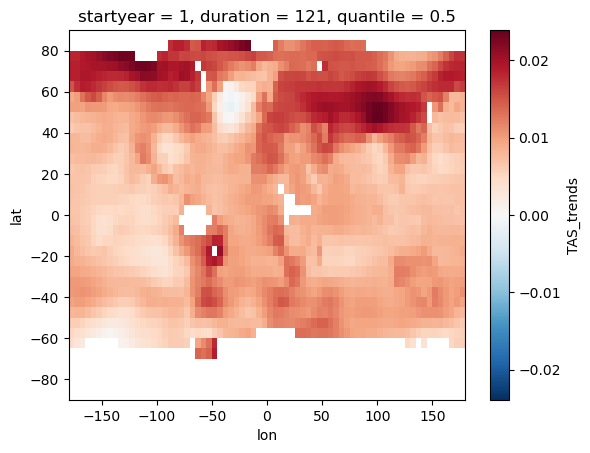

In [ ]:
gistemp_trends_all.sel(duration=121).mean("realization").plot()

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


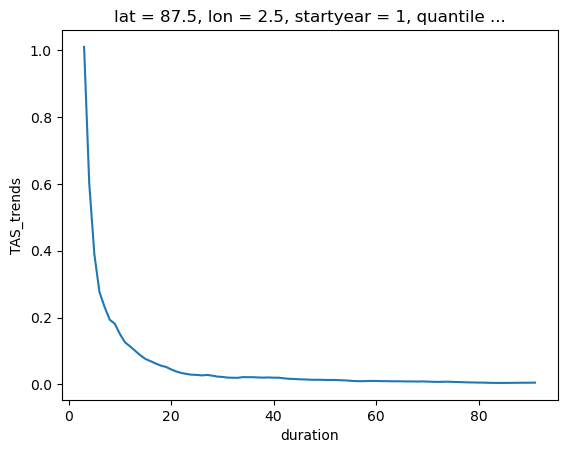

In [30]:
gistemp_trends_all.sel(startyear=1, lat=87.5, lon=2.5).std("realization").plot()

In [33]:
del gistemp_5x5_ds, gistemp_trends_all

#### HadCRUT5

In [66]:
hadcrut5_ds = xr.open_dataset(*hadcrut5_files)

I get a weird error when trying to polyfit data with the form [real, real, nan].

Is this perhaps corrected in more recent version of xarray? __Yes__, though now I get other warnings that I need to suppress

In [84]:
warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")
hadcrut5_trends_all = compute_trends_wrapper(
    hadcrut5_ds[hadcrut5_tas_var],
    # hadcrut5_ds[hadcrut5_tas_var].sel(lat=2.5, lon=2.5),
    durations=np.arange(3,122,1),
    startyears=[1],
    # durations=np.arange(3,5,1),
    time_dim="recordlength",
    metadata=False,
)

3 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


4 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


5 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


6 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


7 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


8 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


9 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


10 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


11 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


12 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


13 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


14 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


15 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


16 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


17 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


18 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


19 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


20 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


21 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


22 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


23 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


24 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


25 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


26 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


27 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


28 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


29 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


30 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


31 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


32 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


33 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


34 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


35 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


36 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


37 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


38 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


39 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


40 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


41 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


42 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


43 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


44 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


45 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


46 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


47 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


48 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


49 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


50 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


51 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


52 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


53 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


54 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


55 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


56 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


57 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


58 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


59 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


60 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


61 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


62 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


63 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


64 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


65 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


66 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


67 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


68 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


69 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


70 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


71 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


72 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


73 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


74 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


75 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


76 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


77 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


78 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


79 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


80 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


81 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


82 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


83 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


84 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


85 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


86 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


87 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


88 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


89 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


90 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


91 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


92 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


93 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


94 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


95 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


96 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


97 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


98 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


99 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


100 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


101 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


102 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


103 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


104 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


105 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


106 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


107 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


108 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


109 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


110 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


111 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


112 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


113 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


114 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


115 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


116 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


117 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


118 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


119 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


120 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


121 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [85]:
hadcrut5_trends_all.sel(startyear=1, lat=87.5, lon=2.5, realization=100)

<xarray.DataArray 'TAS_trends' (duration: 119)> Size: 952B
array([ 1.07071417e+00,  6.36886062e-01,             nan,  6.82134909e-01,
        2.96848011e-01,  2.23405790e-01,  1.89636866e-01,  2.26920071e-01,
        1.71390781e-01,  1.79670337e-01,  1.89288391e-01,  1.48934880e-01,
        1.26095257e-01,  1.06907165e-01,  1.03493257e-01,  7.49152256e-02,
        7.89370595e-02,  7.40949416e-02,  5.11402475e-02,  3.91941884e-02,
        1.86764163e-02,  7.25009761e-03,  1.21248347e-02,  9.66412550e-03,
        1.31207443e-02,  2.49664007e-02,  2.87005807e-02,  2.70134793e-02,
        3.08011146e-02,  2.13878611e-02,  2.12953690e-02,  2.05989873e-02,
        2.04939702e-02,  1.60433335e-02,  8.19654027e-03, -2.42681651e-03,
       -1.00533626e-02, -9.48313714e-03, -1.59046106e-02, -1.29926975e-02,
       -1.52522382e-02, -1.56570283e-02, -1.64923934e-02, -1.49610679e-02,
       -1.22457287e-02, -1.30426122e-02, -1.26165831e-02, -1.34196524e-02,
       -1.39824747e-02, -1.50207801e-02, -1.41826714e-02, -1.70731805e-02,
       -1.77674989e-02, -1.80102571e-02, -1.85531240e-02, -1.95540548e-02,
       -1.52501475e-02, -1.40429240e-02, -1.43135489e-02, -1.51719162e-02,
       -1.56846327e-02, -1.67233691e-02, -1.51199038e-02, -1.34694246e-02,
       -1.39773248e-02, -1.36029245e-02, -1.26410002e-02, -9.74409442e-03,
       -8.50343007e-03, -6.83524086e-03, -4.75452188e-03, -4.14835111e-03,
       -3.30837075e-03, -2.60732304e-03, -1.74250414e-03, -1.26496774e-03,
       -1.19376757e-03,  5.24640444e-04,  2.54891530e-03,  4.62630733e-03,
        5.30873998e-03,  5.88942308e-03,  7.52427322e-03,  9.95590762e-03,
        1.24227904e-02,  1.21673910e-02,  1.35339194e-02,  1.46544998e-02,
        1.66573547e-02,  1.74242120e-02,  1.81226433e-02,  1.91925871e-02,
        2.11218028e-02,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan])
Coordinates:
    realization  int64 8B 100
    lat          float64 8B 87.5
    lon          float64 8B 2.5
    startyear    int64 8B 1
  * duration     (duration) int64 952B 3 4 5 6 7 8 9 ... 116 117 118 119 120 121
    quantile     float64 8B ...

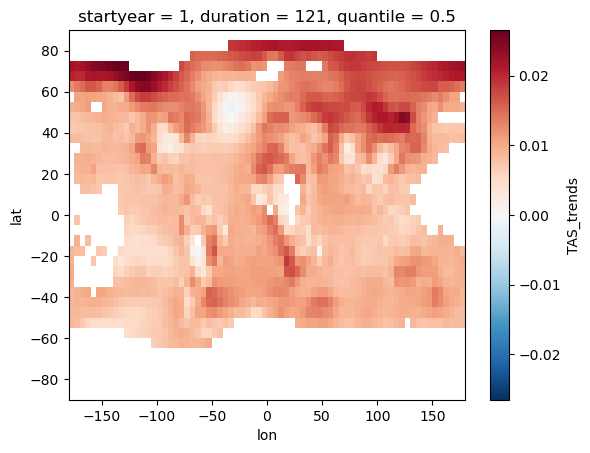

In [86]:
hadcrut5_trends_all.sel(duration=121).mean("realization").plot()

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


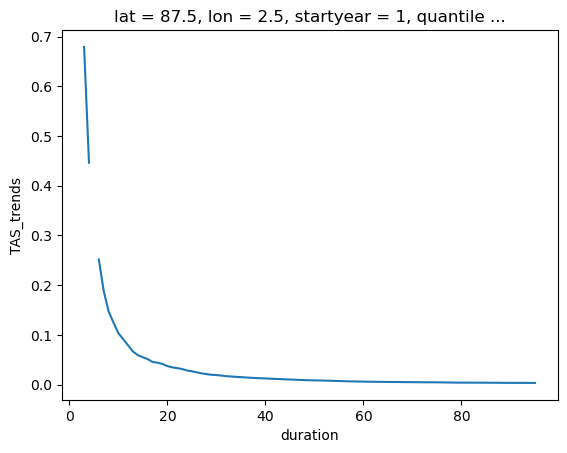

In [87]:
hadcrut5_trends_all.sel(startyear=1, lat=87.5, lon=2.5).std("realization").plot()

In [88]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.5x5.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/xagg'))

In [89]:
del hadcrut5_ds,hadcrut5_trends_all

#### DCENT (unfilled)

In [110]:
dcent_unfilled_ds = xr.open_dataset(*dcent_unfilled_files)

In [113]:
# warnings.filterwarnings("ignore", r"Polyfit may be poorly conditioned")
# warnings.filterwarnings("ignore", r"__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    dcent_unfilled_trends_all = compute_trends_wrapper(
        dcent_unfilled_ds[dcent_unfilled_tas_var],
        # dcent_unfilled_ds[dcent_unfilled_tas_var].sel(lat=2.5, lon=2.5),
        durations=np.arange(3,122,1),
        startyears=[1],
        # durations=np.arange(3,5,1),
        time_dim="recordlength",
        metadata=False,
    )

3 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


4 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


5 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


6 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


7 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


8 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


9 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


10 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


11 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


12 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


13 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


14 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


15 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


16 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


17 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


18 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


19 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


20 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


21 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


22 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


23 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


24 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


25 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


26 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


27 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


28 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


29 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


30 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


31 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


32 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


33 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


34 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


35 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


36 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


37 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


38 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


39 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


40 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


41 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


42 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


43 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


44 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


45 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


46 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


47 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


48 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


49 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


50 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


51 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


52 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


53 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


54 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


55 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


56 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


57 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


58 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


59 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


60 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


61 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


62 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


63 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


64 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


65 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


66 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


67 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


68 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


69 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


70 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


71 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


72 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


73 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


74 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


75 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


76 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


77 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


78 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


79 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


80 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


81 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


82 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


83 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


84 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


85 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


86 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


87 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


88 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


89 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


90 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


91 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


92 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


93 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


94 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


95 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


96 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


97 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


98 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


99 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


100 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


101 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


102 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


103 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


104 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


105 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


106 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


107 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


108 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


109 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


110 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


111 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


112 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


113 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


114 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


115 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


116 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


117 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


118 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


119 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


120 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


121 

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


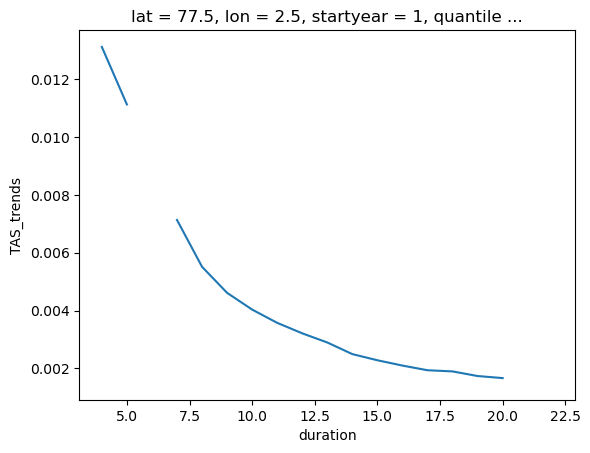

In [116]:
dcent_unfilled_trends_all.sel(startyear=1, lat=77.5, lon=2.5).std("realization").plot()

In [115]:
dcent_unfilled_trends_all.to_netcdf('%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.5x5.190001-202312.nc' % (obslens_tseries_dir,'DCENT/20240901/xagg'))

In [51]:
del dcent_unfilled_ds, dcent_unfilled_trends_all